In [4]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pylab as plt
import copy

import sys
sys.path.append("..")
sys.path.append("../../fdfdpy")

from fdfdpy import Simulation
from structures import three_port, two_port
from optimization import Optimization
from utils import Binarizer

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
lambda0 = 2e-6              # free space wavelength (m)
c0 = 3e8                    # speed of light in vacuum (m/s)
omega = 2*np.pi*c0/lambda0  # angular frequency (2pi/s)
dl = 0.8e-1                 # grid size (L0)
NPML = [15, 15]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')
source_amp = 5             # amplitude of modal source (A/L0^2?)

In [6]:
# material constants
n_index = 2.44              # refractive index
eps_m = n_index**2          # relative permittivity
chi3 = 4.1*1e-19            # Al2S3 from Boyd (m^2/V^2)
# max_ind_shift = 5.8e-3      # maximum allowed nonlinear refractive index shift (computed from damage threshold)

In [7]:
# geometric parameters
L = 10         # length of box (L0)
H = 0.3         # height of box (L0)
w = .3        # width of waveguides (L0)
d = H/2.44    # distance between waveguides (L0)
l = 4         # length of waveguide from PML to box (L0)
spc = 3       # space between box and PML (L0)

Computed a domain with 255 grids in x and 108 grids in y
The simulation has 25 grids per free space wavelength


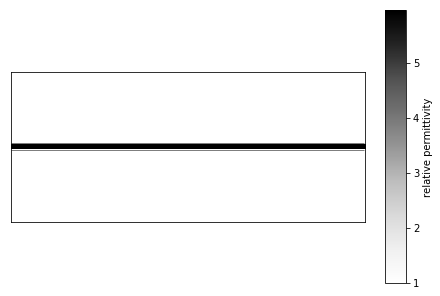

In [8]:
# define permittivity of three port system
eps_r, design_region = two_port(L, H, w, l, spc, dl, NPML, eps_m)
(Nx, Ny) = eps_r.shape
nx, ny = int(Nx/2), int(Ny/2)            # halfway grid points

simulation = Simulation(omega,eps_r,dl,NPML,pol)
# compute the grid size the total grid size
print("Computed a domain with {} grids in x and {} grids in y".format(Nx,Ny))
print("The simulation has {} grids per free space wavelength".format(int(lambda0/dl/simulation.L0)))
simulation.plt_eps()
plt.show()

In [9]:
# set the modal source and probes
simulation = Simulation(omega, eps_r, dl, NPML, 'Ez')
simulation.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny], int(10*H/dl), scale=source_amp)
simulation.setup_modes()

# top modal profile
out = Simulation(omega, eps_r, dl, NPML, 'Ez')
out.add_mode(np.sqrt(eps_m), 'x', [-NPML[0]-int(l/2/dl), ny], int(10*H/dl))
out.setup_modes()
J_out = np.abs(out.src)

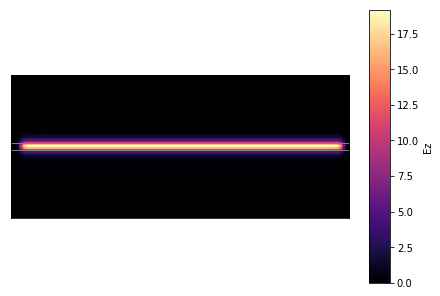

In [10]:
# set source and solve for electromagnetic fields
(_, _, Ez) = simulation.solve_fields()
simulation.plt_abs(outline=True, cbar=True);

In [11]:
# compute straight line simulation
eps_r_wg, _ = two_port(L, H, w, l, spc, dl, NPML, eps_start=eps_m)
(Nx_wg, Ny_wg) = eps_r_wg.shape
nx_wg, ny_wg = int(Nx_wg/2), int(Ny_wg/2)            # halfway grid points     
simulation_wg = Simulation(omega, eps_r_wg, dl, NPML, 'Ez')
simulation_wg.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny_wg], int(10*H/dl), scale=source_amp)
simulation_wg.setup_modes()

# compute normalization
sim_out = Simulation(omega, eps_r_wg, dl, NPML, 'Ez')
sim_out.add_mode(np.sqrt(eps_m), 'x', [-NPML[0]-int(l/2/dl), ny], int(10*H/dl))
sim_out.setup_modes()
J_out = np.abs(sim_out.src)
(_, _, Ez_wg) = simulation_wg.solve_fields()
SCALE = np.sum(np.square(np.abs(Ez_wg))*J_out)
print('computed a scale of {} in units of E^2 J_out'.format(SCALE))

computed a scale of 638.5312822310406 in units of E^2 J_out


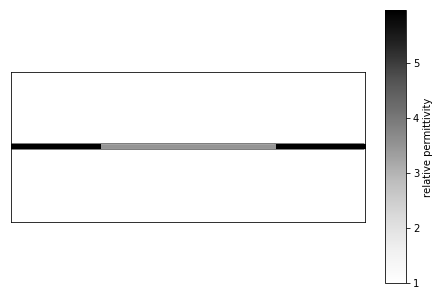

In [12]:
# changes design region. 'style' can be in {'full', 'empty', 'halfway', 'random'}
simulation.init_design_region(design_region, eps_m, style='halfway')
simulation.plt_eps()
plt.show()

In [13]:
# add nonlinearity
nl_region = copy.deepcopy(design_region)

simulation.nonlinearity = []  # This is needed in case you re-run this cell, for example (or you can re-initialize simulation every time)
simulation.add_nl(chi3, nl_region, eps_scale=True, eps_max=eps_m)

In [14]:
# define objective function
import autograd.numpy as npa
def J(e, e_nl, eps):
    """ objective function of BOOST means perfect separation between linear and nonlinear
        note: need BOOST if the objective function is too low (source amplitude is low).
        In this case LBFGS just converges and returns before it's actually done.
        Working on this.
    """
    BOOST = 1
    linear_out =     1*npa.sum(npa.square(npa.abs(e))*J_out)
    nonlinear_out = -1*npa.sum(npa.square(npa.abs(e_nl))*J_out)
    objfn = linear_out + nonlinear_out
    objfn_binary = objfn
    return objfn_binary / SCALE * BOOST

In [18]:
# make optimization object and check derivatives
optimization = Optimization(J=J, Nsteps=100, eps_max=eps_m, field_start='linear', nl_solver='newton')

# check the derivatives (note, full derivatives are checked, linear and nonlinear no longer separate)
(grad_avm, grad_num) = optimization.check_deriv(simulation, design_region, Npts=4)
print('adjoint gradient   = {}\nnumerical gradient = {}'.format(grad_avm, grad_num))

adjoint gradient   = [2.1133700677684864e-261, -6.727363922930124e-262, -2.9823044298638872e-261, 3.74224305575242e-261]
numerical gradient = [7.773517990899504e-06, -2.4743125930581315e-06, -1.0969116063516216e-05, 1.3764557674889434e-05]


 ObjectiveFn:  0.802 Iteration:  27/28 ETA:   0:00:02                          

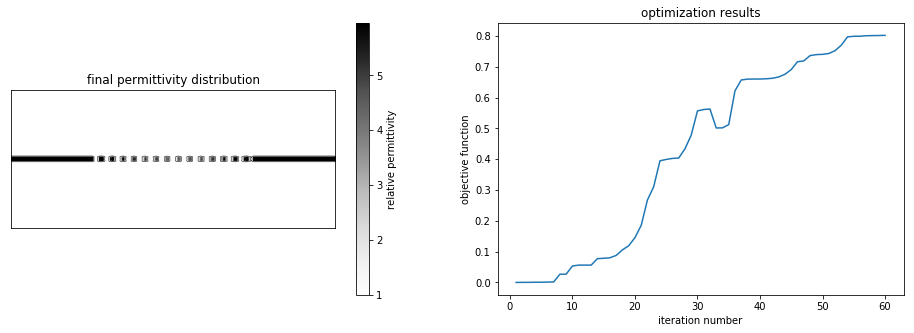

In [14]:
optimization.J = J
optimization.Nsteps = 200
new_eps = optimization.run(simulation, design_region, method='lbfgs')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
simulation.plt_eps(ax=ax1)
ax1.set_title('final permittivity distribution')
optimization.plt_objs(ax=ax2)
ax2.set_yscale('linear')
plt.show()

 ObjectiveFn:  0.525 Iteration:  49/50 ETA:   0:00:02                          

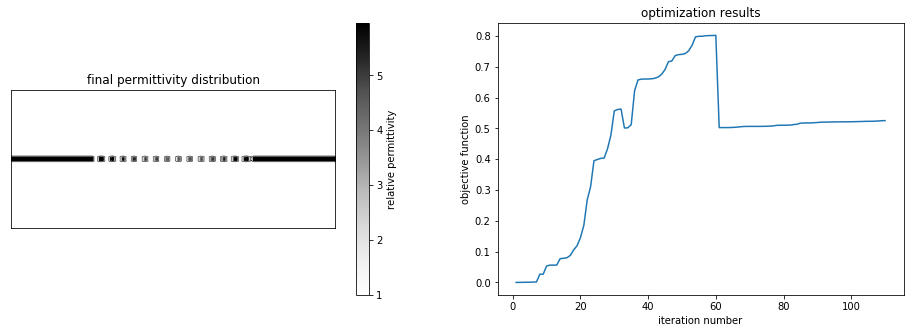

In [15]:
binarizer = Binarizer(design_region, eps_m, exp_const=1)
J_bin = binarizer.density_exp(J)
optimization.J = J_bin
optimization.Nsteps = 100
new_eps = optimization.run(simulation, design_region, method='lbfgs')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
simulation.plt_eps(ax=ax1)
ax1.set_title('final permittivity distribution')
optimization.plt_objs(ax=ax2)
ax2.set_yscale('linear')
plt.show()

the simulation did not converge, reached 0.02119603892749042


 ObjectiveFn:  0.352 Iteration:  49/50 ETA:   0:00:02                          

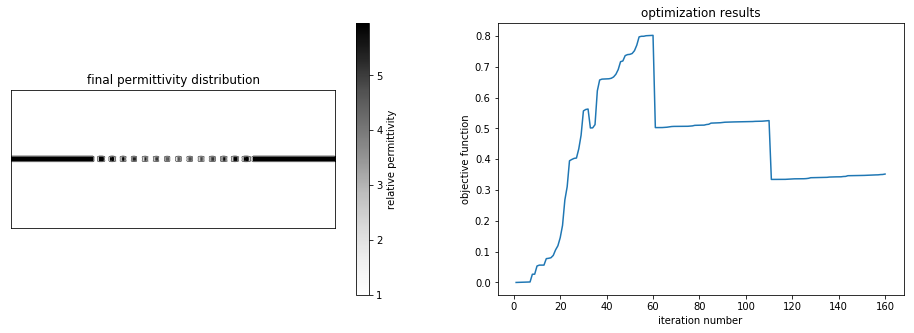

In [16]:
binarizer = Binarizer(design_region, eps_m, exp_const=2)
J_bin = binarizer.density_exp(J)
optimization.J = J_bin
optimization.Nsteps = 50
new_eps = optimization.run(simulation, design_region, method='lbfgs')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
simulation.plt_eps(ax=ax1)
ax1.set_title('final permittivity distribution')
optimization.plt_objs(ax=ax2)
ax2.set_yscale('linear')
plt.show()

 ObjectiveFn:  0.255 Iteration:  49/50 ETA:   0:00:02                          

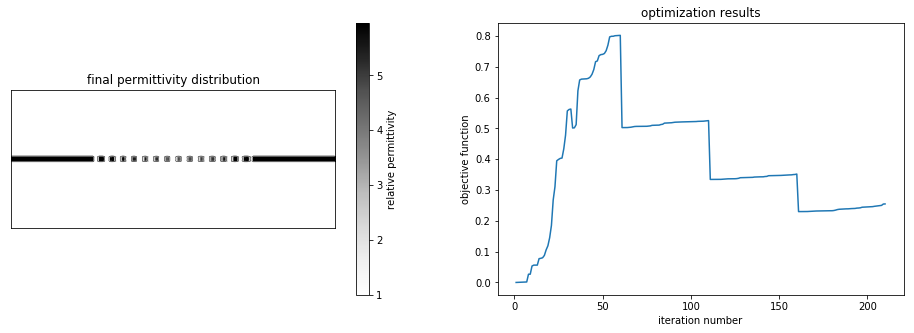

In [17]:
binarizer = Binarizer(design_region, eps_m, exp_const=3)
J_bin = binarizer.density_exp(J)
optimization.J = J_bin
optimization.Nsteps = 50
new_eps = optimization.run(simulation, design_region, method='lbfgs')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
simulation.plt_eps(ax=ax1)
ax1.set_title('final permittivity distribution')
optimization.plt_objs(ax=ax2)
ax2.set_yscale('linear')
plt.show()

 ObjectiveFn:  0.189 Iteration:  49/50 ETA:   0:00:02                          

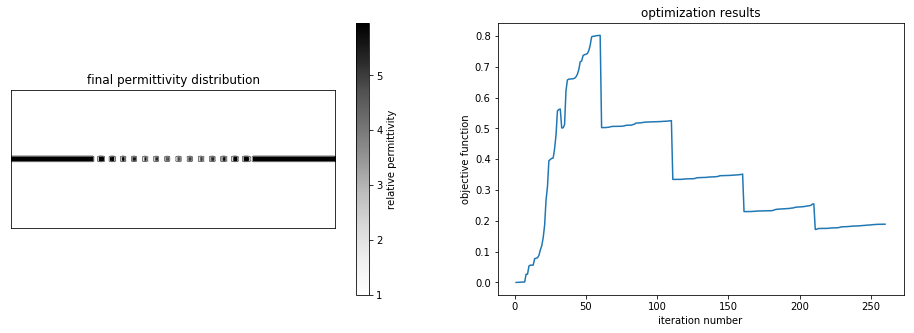

In [18]:
binarizer = Binarizer(design_region, eps_m, exp_const=4)
J_bin = binarizer.density_exp(J)
optimization.J = J_bin
optimization.Nsteps = 50
new_eps = optimization.run(simulation, design_region, method='lbfgs')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
simulation.plt_eps(ax=ax1)
ax1.set_title('final permittivity distribution')
optimization.plt_objs(ax=ax2)
ax2.set_yscale('linear')
plt.show()

In [50]:
binarizer = Binarizer(design_region, eps_m, exp_const=8)
J_bin = binarizer.density_exp(J)
optimization.J = J_bin
optimization.Nsteps = 5000
new_eps = optimization.run(simulation, design_region, method='lbfgs')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
simulation.plt_eps(ax=ax1)
ax1.set_title('final permittivity distribution')
optimization.plt_objs(ax=ax2)
ax2.set_yscale('linear')
plt.show()

KeyboardInterrupt: 

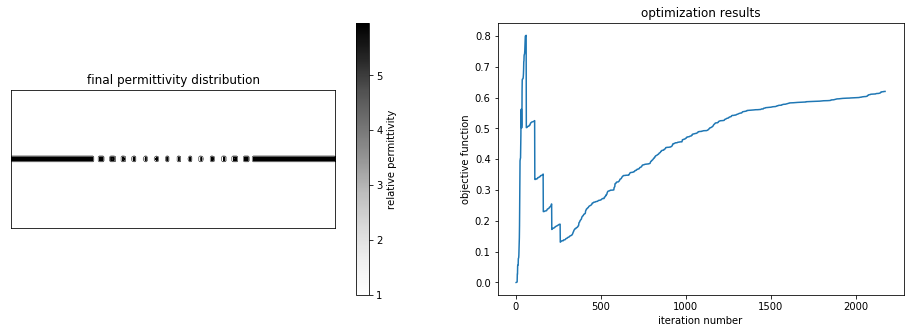

In [23]:
# plot optimization results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
simulation.plt_eps(ax=ax1)
ax1.set_title('final permittivity distribution')
optimization.plt_objs(ax=ax2)
ax2.set_yscale('linear')
plt.show()

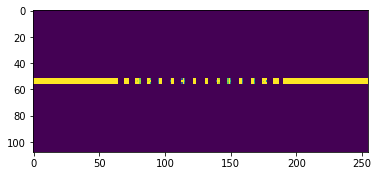

In [26]:
plt.imshow(simulation.eps_r.T)
plt.show()

original objective function of 0.9044994625154472
best objective function of 0.0037820828301683177 at threshold of 2.1973684210526314


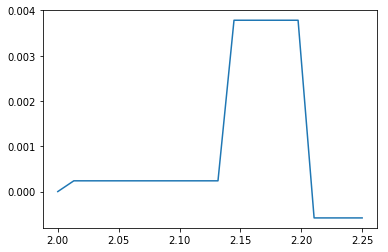

In [48]:
Nb = 20
Js = []
eps_range = np.linspace(1,eps_m,Nb)
eps_range = np.linspace(2,2.25,Nb)
(_,_,Ez) = simulation.solve_fields()
(_,_,Ez_nl,_) = simulation.solve_fields_nl()
J_orig = J(Ez, Ez_nl, simulation.eps_r)
print('original objective function of {}'.format(J_orig))

e_best = 0
J_best = 0
for e in eps_range:
    eps_test = copy.deepcopy(simulation.eps_r)
    eps_test[simulation.eps_r<e] = 1
    eps_test[simulation.eps_r>=e] = eps_m
    sim_test = copy.deepcopy(simulation)
    sim_test.eps_r = eps_test
    (_,_,Ez) = sim_test.solve_fields()
    (_,_,Ez_nl,_) = sim_test.solve_fields_nl()
    objfn = J(Ez, Ez_nl, eps_test)
    if objfn > J_best:
        e_best = e
        J_best = objfn
    Js.append(objfn)
print('best objective function of {} at threshold of {}'.format(J_best, e_best))
plt.plot(eps_range, Js)
plt.show()

eps_best = copy.deepcopy(simulation.eps_r)
eps_best[simulation.eps_r<e_best] = 1
eps_best[simulation.eps_r>=e_best] = eps_m
simulation_binarized = copy.deepcopy(simulation)
simulation_binarized.eps_r = eps_best



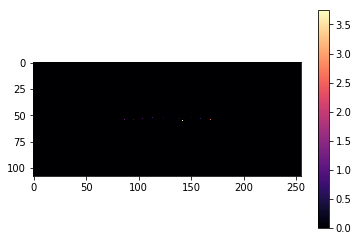

In [60]:
eps_new = simulation.eps_r
plt.imshow(np.abs(eps_new.T - eps_best.T), cmap='magma')
plt.colorbar()

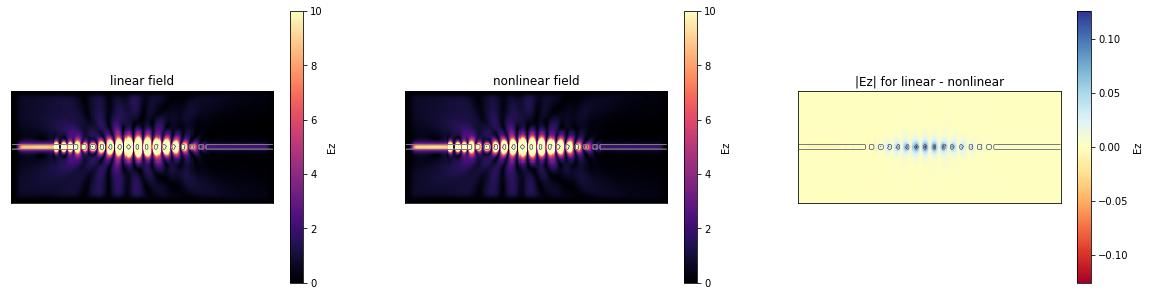

In [49]:
# BINARIZED

# setup subplots
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))

# linear fields
(Hx,Hy,Ez) = simulation_binarized.solve_fields()
simulation_binarized.plt_abs(ax=ax1, vmax=10)
ax1.set_title('linear field')

# nonlinear fields
(Hx_nl,Hy_nl,Ez_nl,_) = simulation_binarized.solve_fields_nl()
simulation_binarized.plt_abs(ax=ax2, vmax=10, nl=True)
ax2.set_title('nonlinear field')

# difference
simulation_binarized.plt_diff(ax=ax3)
ax3.set_title('|Ez| for linear - nonlinear')

plt.show()

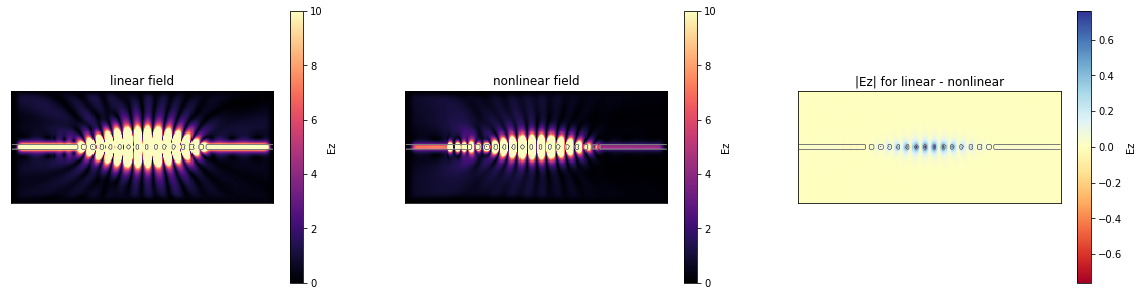

In [55]:
# compare the linear and nonlinear fields

# setup subplots
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))

# linear fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs(ax=ax1, vmax=10)
ax1.set_title('linear field')

# nonlinear fields
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl()
simulation.plt_abs(ax=ax2, vmax=10, nl=True)
ax2.set_title('nonlinear field')

# difference
simulation.plt_diff(ax=ax3)
ax3.set_title('|Ez| for linear - nonlinear')

plt.show()

maximum refractive index shift of 0.0033679159154611504


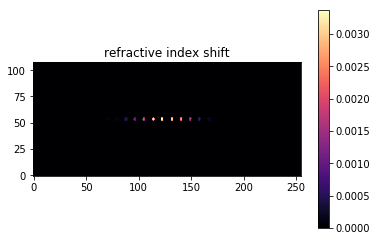

In [45]:
# compute the refractive index shift
index_shift = simulation.compute_index_shift()
print('maximum refractive index shift of {}'.format(np.max(index_shift)))
plt.imshow(index_shift.T, cmap='magma', origin='lower')
plt.colorbar()
plt.title('refractive index shift')
plt.show()

In [56]:
# compute powers

# input power
W_in = simulation.W_in

# linear powers
(Hx,Hy,Ez) = simulation.solve_fields()
W_out_lin = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny], int(Ny/2))
W_in_lin = simulation.flux_probe('x', [NPML[0]+int(2*l/3/dl), ny], int(Ny/2))

T_lin = W_out_lin/W_in

# nonlinear powers
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl()
W_out_nl = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny], int(Ny/2))
W_in_nl = simulation.flux_probe('x', [NPML[0]+int(2*l/3/dl), ny], int(Ny/2))

T_nl = W_out_nl/W_in

print('linear transmission              = {:.4f}'.format(T_lin))
print('nonlinear transmission           = {:.4f}\n'.format(T_nl))
print('relative power difference        = {:.2f} %'.format(100*abs(W_out_lin-W_out_nl)/W_out_lin))
print('relative transmission difference = {:.2f} %'.format(100*abs(T_lin-T_nl)/T_lin))


linear transmission              = 0.9510
nonlinear transmission           = 0.9510

relative power difference        = 0.00 %
relative transmission difference = 0.00 %


In [ ]:
freqs, objs, FWHM = optimization.scan_frequency(Nf=200, df=1/400)
optimization.simulation.omega = omega
plt.plot([(f-150e12)/1e9 for f in freqs], objs)
plt.xlabel('frequency difference (GHz)')
plt.ylabel('objective function')
plt.show()
print('computed FWHM of {} (GHz):'.format(FWHM/1e9))
print('Q factor of {0:.2E}'.format(omega/2/np.pi/FWHM))

In [ ]:
np.save('../data/figs/data1/2port_eps', simulation.eps_r)
np.save('../data/figs/data1/2port_objfn_list', optimization.objfn_list)
np.save('../data/figs/data1/2port_freqs', freqs)
np.save('../data/figs/data1/2port_objs', objs)
